In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [91]:
dataset = pd.read_csv('../secondMMRintData/testInitialcondSim.csv')

In [92]:
dataset.loc[0]

index                                    0
EMcrossnear                       0.221502
MMRstrengthnear                   0.098431
twoMMRstrengthnear                0.009879
MMRinWidnear                         False
MMRstrengthWnear                  0.013615
twoMMRinWidnear                       True
twoMMRstrengthWnear               0.007075
EMcrossfar                        0.300893
MMRstrengthfar                    0.093415
twoMMRstrengthfar                 0.001595
MMRinWidfar                           True
MMRstrengthWfar                   0.008864
twoMMRinWidfar                        True
twoMMRstrengthWfar                0.001976
EMcrossouter                      0.589043
MMRstrengthouter                  0.440409
twoMMRstrengthouter                    0.0
MMRinWidouter                        False
MMRstrengthWouter                  0.00433
twoMMRinWidouter                         0
twoMMRstrengthWouter                   0.0
MEGNO                                  0.0
threeBRfill

In [93]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [94]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 6.04 s, sys: 52 ms, total: 6.09 s
Wall time: 6.09 s


In [95]:
dataset['EMavg'] = (dataset['EMcrossfar']+dataset['EMcrossnear']+dataset['EMcrossouter'])/3

In [96]:
dataset['Widavg']= (dataset['MMRstrengthWnear']+dataset['MMRstrengthWfar']+dataset['MMRstrengthWouter'])/3

In [101]:
#removed twoMMRs 
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
outer = ['EMcrossouter', 'EMfracstdouter', 'EPstdouter', 'MMRstrengthouter','twoMMRstrengthouter']
megno = ['MEGNO', 'MEGNOstd']
threeBR = ['threeBRfillfac', 'threeBRfillstd']
#what is being used to train

twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

features = near + far + outer + megno + threeBR + twoBRwidth +twoBRinW
OGfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']
Oldfeatures = near + far + outer + megno + threeBR 
threeMegno = threeBR+OGfeatures
MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','twoMMRstrengthnear','twoMMRstrengthfar','twoMMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd']+twoBRwidth

TestFirst = ['threeBRfillfac', 'threeBRfillstd','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter']

testfew = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter', 'threeBRfillfac','EMcrossnear','EMcrossfar','EMcrossouter']

testavg = ['EMavg','Widavg','threeBRfillfac']

In [102]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [103]:
filtData['pomegastd']

0         1.738816
1         1.499655
2         2.107649
3         3.048630
4         1.309736
            ...   
138538    1.658464
138539    1.212782
138540    2.752498
138541    1.021228
138542    2.608255
Name: pomegastd, Length: 138543, dtype: float64

In [104]:
scrambled = filtData.sample(frac=1)

In [105]:
scrambled = scrambled.reset_index()

In [106]:
scrambled

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,EMcrossfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,118844,118844,0.069125,0.159062,0.022129,False,0.001430,True,0.002963,0.245997,...,0.002488,0.001719,0.001614,True,False,7.037319e+04,6.403669e+04,0,0.215750,0.000867
1,40223,40223,0.093316,0.315855,0.005221,False,0.001947,True,0.001988,0.226330,...,0.013651,0.088374,0.021825,True,False,7.605144e+06,5.099123e+06,0,0.220138,0.003231
2,15656,15656,0.298789,0.030426,0.000142,True,0.003534,True,0.000165,0.504441,...,0.119219,0.140282,0.078058,True,True,1.000008e+09,1.000008e+09,0,0.585728,0.002429
3,18203,18203,0.043649,0.139023,0.017147,False,0.002615,True,0.002605,0.572505,...,0.000092,0.001639,0.000061,True,False,7.602421e+03,3.535479e+04,0,0.419099,0.004476
4,75921,75921,0.052575,2.866308,1.021745,False,0.018913,False,0.095619,0.151049,...,0.030772,0.163182,0.034815,True,False,1.341006e+04,9.668273e+03,0,0.138396,0.010624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,73201,73201,0.093779,1.010805,0.053300,False,0.019280,True,0.019682,0.311751,...,0.011650,0.069285,0.008306,True,False,4.433063e+04,4.833132e+04,0,0.280098,0.012790
138539,96619,96619,0.211884,0.633114,0.000953,False,0.004110,True,0.000853,0.212120,...,0.021493,0.148656,0.133666,True,False,1.177032e+05,9.628703e+04,0,0.297651,0.005434
138540,111485,111485,0.118282,0.335324,0.056656,False,0.007004,True,0.013420,0.209238,...,0.013646,0.220995,0.130572,True,False,1.794668e+05,9.150920e+04,0,0.226596,0.012801
138541,110503,110503,0.099747,0.086785,0.024360,False,0.001571,True,0.004681,0.183172,...,0.021936,0.015892,0.019474,True,False,9.634037e+04,7.603762e+04,0,0.194704,0.002754


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [108]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [109]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [110]:
realTest = test.loc[test['prelimStable']==True]

In [111]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [112]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [113]:
from sklearn.metrics import accuracy_score

In [114]:
train

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,EMcrossfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,118844,118844,0.069125,0.159062,0.022129,False,0.001430,True,0.002963,0.245997,...,0.002488,0.001719,0.001614,True,False,7.037319e+04,6.403669e+04,0,0.215750,0.000867
1,40223,40223,0.093316,0.315855,0.005221,False,0.001947,True,0.001988,0.226330,...,0.013651,0.088374,0.021825,True,False,7.605144e+06,5.099123e+06,0,0.220138,0.003231
2,15656,15656,0.298789,0.030426,0.000142,True,0.003534,True,0.000165,0.504441,...,0.119219,0.140282,0.078058,True,True,1.000008e+09,1.000008e+09,0,0.585728,0.002429
3,18203,18203,0.043649,0.139023,0.017147,False,0.002615,True,0.002605,0.572505,...,0.000092,0.001639,0.000061,True,False,7.602421e+03,3.535479e+04,0,0.419099,0.004476
4,75921,75921,0.052575,2.866308,1.021745,False,0.018913,False,0.095619,0.151049,...,0.030772,0.163182,0.034815,True,False,1.341006e+04,9.668273e+03,0,0.138396,0.010624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110829,138327,138327,0.108371,0.636021,0.004999,False,0.002207,True,0.002270,0.146342,...,0.038517,0.069414,0.058814,True,False,2.503050e+06,1.256588e+06,0,0.175095,0.001281
110830,118917,118917,0.081905,0.211154,0.004667,False,0.001507,True,0.001531,0.168853,...,0.035184,0.038760,0.033417,True,False,1.542670e+08,3.001508e+08,0,0.171782,0.001522
110831,94593,94593,0.405611,15.484405,0.035615,False,0.032458,False,0.067294,0.475272,...,0.133814,0.504629,0.394525,True,False,4.671087e+05,7.199624e+05,0,0.651514,0.014959
110832,123830,123830,0.242184,0.123562,0.011826,False,0.001111,True,0.002612,0.589646,...,0.031382,0.054870,0.029488,True,False,2.035276e+07,1.458667e+07,0,0.602155,0.004946


In [150]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [151]:
testModel.fit(train[testavg], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [154]:
resPred = testModel.predict_proba(tT[testavg])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[testavg]), tT["Stable"]))

0.829554032644269
0.7370846804705234


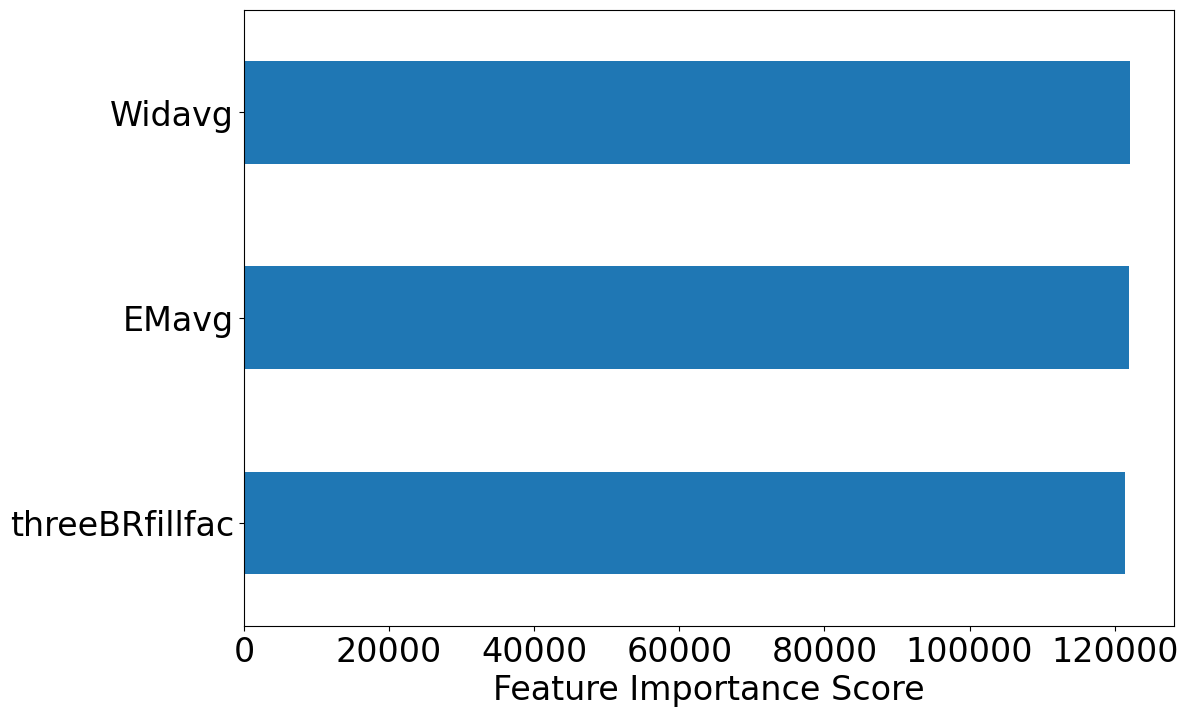

In [153]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0.0, 20.0)

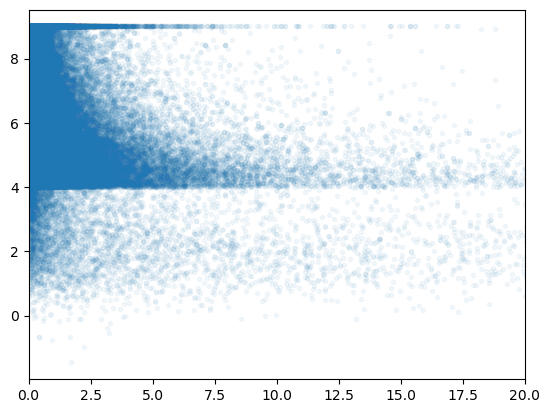

In [27]:
plt.plot(train['threeBRfillfac'],np.log10(train['instability_time']), '.', alpha = .05)
ax = plt.gca()
ax.set_xlim([0,20])


In [28]:
which = (filtData['MMRstrengthnear']+filtData['MMRstrengthfar']+filtData['MMRstrengthouter'])/3

In [29]:
filtData['avarage']=which

In [30]:
np.median(filtData['avarage'])

0.14079908670065772

In [33]:
plot = filtData.drop(filtData[filtData['Widavg'] >.1].index)

/tmp/ipykernel_23824/1703491278.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['Widavg'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.5)


(4.0, 9.0)

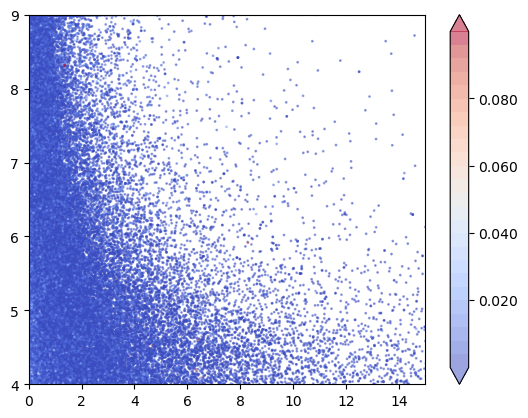

In [34]:
ax = plt.axes()
plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['Widavg'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.5)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,15])
ax.set_ylim([4,9])

(0.0, 30.0)

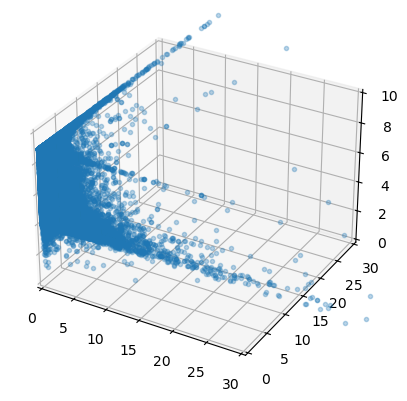

In [53]:
ax = plt.axes(projection='3d')
ax.plot3D(train['threeBRfillfac'], train['MMRstrengthnear'],np.log10(train['instability_time']),'.', alpha = 0.3)
ax.set_xlim([0,30])
ax.set_zlim([0,10])
ax.set_ylim([0,30])

In [120]:
test['spockres'] = testModel.predict(test[MMRDATA])

/tmp/ipykernel_23824/1980874473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['spockres'] = testModel.predict(test[MMRDATA])


In [36]:
regtest = test.drop(test[test['instability_time'] >=1e9].index)


In [121]:
test

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,EMcrossfar,...,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,spockres
110834,28623,28623,0.371990,0.019563,0.006857,True,0.002472,True,0.003948,0.516123,...,0.059041,0.035316,True,False,2.689905e+06,1.388138e+07,0,0.656073,0.003111,1
110835,69249,69249,0.070013,0.121733,0.075546,False,0.002631,False,0.007652,0.169723,...,0.012004,0.011525,True,False,2.285046e+06,9.885070e+05,0,0.163785,0.002628,0
110836,126953,126953,0.134456,0.104013,0.009641,False,0.000125,True,0.001074,0.399606,...,0.060579,0.063726,True,False,1.199777e+05,2.158910e+05,0,0.373951,0.003074,0
110837,122796,122796,0.151126,0.088109,0.084463,False,0.001135,False,0.013893,0.391030,...,0.062948,0.014957,True,False,1.782515e+05,1.000000e+09,0,0.381136,0.002783,0
110838,113465,113465,0.069015,1.181315,0.013833,False,0.001337,True,0.001909,0.077526,...,0.018324,0.008897,True,False,8.174826e+05,1.343023e+05,0,0.099477,0.001439,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,73201,73201,0.093779,1.010805,0.053300,False,0.019280,True,0.019682,0.311751,...,0.069285,0.008306,True,False,4.433063e+04,4.833132e+04,0,0.280098,0.012790,0
138539,96619,96619,0.211884,0.633114,0.000953,False,0.004110,True,0.000853,0.212120,...,0.148656,0.133666,True,False,1.177032e+05,9.628703e+04,0,0.297651,0.005434,0
138540,111485,111485,0.118282,0.335324,0.056656,False,0.007004,True,0.013420,0.209238,...,0.220995,0.130572,True,False,1.794668e+05,9.150920e+04,0,0.226596,0.012801,0
138541,110503,110503,0.099747,0.086785,0.024360,False,0.001571,True,0.004681,0.183172,...,0.015892,0.019474,True,False,9.634037e+04,7.603762e+04,0,0.194704,0.002754,0


In [123]:
test['spockright'] = test['Stable']==test['spockres']

/tmp/ipykernel_23824/1426527784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['spockright'] = test['Stable']==test['spockres']


In [124]:
test

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,EMcrossfar,...,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,spockres,spockright
110834,28623,28623,0.371990,0.019563,0.006857,True,0.002472,True,0.003948,0.516123,...,0.035316,True,False,2.689905e+06,1.388138e+07,0,0.656073,0.003111,1,False
110835,69249,69249,0.070013,0.121733,0.075546,False,0.002631,False,0.007652,0.169723,...,0.011525,True,False,2.285046e+06,9.885070e+05,0,0.163785,0.002628,0,True
110836,126953,126953,0.134456,0.104013,0.009641,False,0.000125,True,0.001074,0.399606,...,0.063726,True,False,1.199777e+05,2.158910e+05,0,0.373951,0.003074,0,True
110837,122796,122796,0.151126,0.088109,0.084463,False,0.001135,False,0.013893,0.391030,...,0.014957,True,False,1.782515e+05,1.000000e+09,0,0.381136,0.002783,0,True
110838,113465,113465,0.069015,1.181315,0.013833,False,0.001337,True,0.001909,0.077526,...,0.008897,True,False,8.174826e+05,1.343023e+05,0,0.099477,0.001439,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,73201,73201,0.093779,1.010805,0.053300,False,0.019280,True,0.019682,0.311751,...,0.008306,True,False,4.433063e+04,4.833132e+04,0,0.280098,0.012790,0,True
138539,96619,96619,0.211884,0.633114,0.000953,False,0.004110,True,0.000853,0.212120,...,0.133666,True,False,1.177032e+05,9.628703e+04,0,0.297651,0.005434,0,True
138540,111485,111485,0.118282,0.335324,0.056656,False,0.007004,True,0.013420,0.209238,...,0.130572,True,False,1.794668e+05,9.150920e+04,0,0.226596,0.012801,0,True
138541,110503,110503,0.099747,0.086785,0.024360,False,0.001571,True,0.004681,0.183172,...,0.019474,True,False,9.634037e+04,7.603762e+04,0,0.194704,0.002754,0,True


In [127]:
tR = test.drop(test[test['spockright'] ==False].index)

In [128]:
tW = test.drop(test[test['spockright'] ==True].index)

In [144]:
plot = tR.drop(tR[tR['EMavg']>.5 ].index)

/tmp/ipykernel_23824/905772591.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['EMavg'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.7)


(4.0, 9.0)

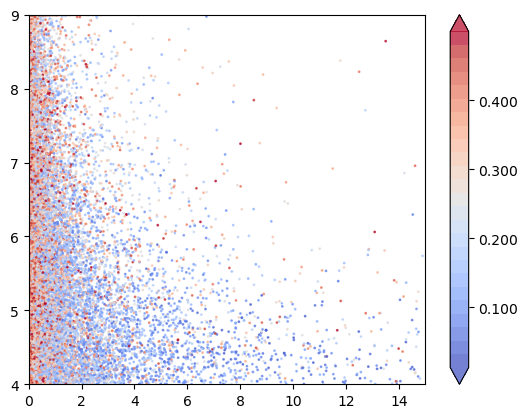

In [149]:
ax = plt.axes()
plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['EMavg'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.7)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,15])
ax.set_ylim([4,9])